# Mark Zuckerberg U.S Hearings 2018

So the main thing here is going to be the comparison between the narritives told by Zuckerberg vs the U.S. congress. Using the transcripts shared by the bloomberg goverment website and used by the wall street journal, thet parsed.


In [1]:
import collections
import time
import re

# --- third party modules. ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer

from IPython.core.display import HTML, display

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# --- local modules. ---
import rake

# --- set up keyword extractor. ---
stopwords = set(open('stopwords').read().split())

stopwords = stopwords | set('''
mr congressman senator chairman gentlemen gentleman yield
time recognizes chair gentlelady expired crosstalk laughter
'''.split())

keyext    = rake.KeywordExtractor(stopwords)
collectop = rake.CollectionOperator(keyext)

# --- load the data ---
h1 = pd.read_csv('hearing1.csv')
h2 = pd.read_csv('hearing2.csv')


plt.style.use('seaborn-darkgrid')


# --- functions ---

def collection_keywords(df):
    'return the most essetinial keywords of the collection.'
    return collections.Counter(collectop.fit(list(df.speech)))


def count_keywords(df):
    c = collections.Counter()
    for k in df.keywords:
        c.update(k)
    return c


def plot_counter(ax, counter, n=15, title=None, size=(5,6)):
    labels, values = list(zip(*counter.most_common(n)[::-1]))
    ind = np.arange(len(labels))
    width = 0.8
    a = ax.barh(ind, values, width)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.legend(a, ("counts",))
    if title is not None:
        ax.set_title(title, y=1.05)
        

def plot_ngrams(series, n0, n1, top=20, **kwargs):
    z = n1 - n0
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 6)
    for i in range(z):
        tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                     max_features=5000,
                                     ngram_range=(n0 + i, n0 + i + 1),
                                     stop_words=stopwords)
        tfidf_features = tfidf_vect.fit_transform(series)
        vocab = tfidf_vect.get_feature_names()
        values = tfidf_features.toarray().sum(axis=0)
        sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:top])
        dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
        dd.plot(kind="barh", ax=axis[i], legend=False, **kwargs).invert_yaxis()
    plt.tight_layout()
    plt.show()


def clean_text(series):
    '''converts the text to lowercase remove all non words,
    stopwords, non ascii characters and links. stem the remaining
    words and concatinate the result into a new string.'''
    return cat(stemmer.stem(w) for w in rx0.findall(series.lower())
                if 3 < len(w) < 20
                if w not in stopwords)

rx0     = re.compile(r"\w+")
cat     = " ".join
stemmer = SnowballStemmer("english")
    
    
def print_overlaps(k0, k1, n=100):
    k0 = dict(k0.most_common(n))
    k1 = dict(k1.most_common(n))
    ks0 = set(k0)
    ks1 = set(k1)
    
    wit = sorted(ks0 - ks1, reverse=True, key=lambda a:  k0[a])
    bot = sorted(ks0 & ks1, reverse=True, key=lambda a: (k0[a] + k1[a]) / 2)
    con = sorted(ks1 - ks0, reverse=True, key=lambda a:  k1[a])
    
    mab = lambda i, x: [a[i] if len(a) > i else '' for a in x]
    it = (wit, bot, con)
    print('{:30} {:30} {:30}'.format('WITNESS', 'BOTH', 'CONGRESS'))
    print('-'*93)
    for i in range(20):
        print('{:30} {:30} {:30}'.format(*mab(i, it)))

        
def extract_topics(series, title, iters=1000, n_features=5000, n_topics=5, n_samples=40):
    '''
    
    '''
    def print_top_words(model, feature_names, n_top_words):
        ol = [", ".join([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
             for topic_idx, topic in enumerate(model.components_)]
        display(HTML("<ol><li>{}</li></ol>".format("</li><li>".join(ol))))
    
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5, 
                                       min_df=2, 
                                       max_features=n_features,
                                       stop_words=stopwords,
                                       ngram_range=(2,3))

    tfidf_features = tfidf_vectorizer.fit_transform(series)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
          "tf-idf features,\nnumber of topics=%d\nn_samples=%d and n_features=%d..." 
          % (n_topics, n_samples, n_features))
    
    t0 = time.time()
    nmf = NMF(n_components=n_topics, random_state=1,
              beta_loss='kullback-leibler', solver='mu', 
              max_iter=iters, alpha=.1, l1_ratio=.5).fit(tfidf_features)
    print("time: {:.2f} secs".format(time.time() - t0))
    print("iters", nmf.n_iter_)
    
    display(HTML("<h3>{}</h3>".format(title)))
    print_top_words(nmf, tfidf_feature_names, n_samples)

## Feature engineering

In [2]:
def build_features(df):
    'add extra features to the dataset here'
    df['role']     = df.name.apply(lambda a: 'WITNESS' if a == 'ZUCKERBERG' else 'CONGRESS')
    df['words']    = df.speech.apply(lambda a: len(a.split()))
    df['keywords'] = df.speech.apply(keyext.keywords)
    df['keyslen']  = df.keywords.apply(len)
    df['cleaned']  = df.speech.apply(clean_text)
    return df

h1 = build_features(h1)
h2 = build_features(h2)

## Rake Keywords

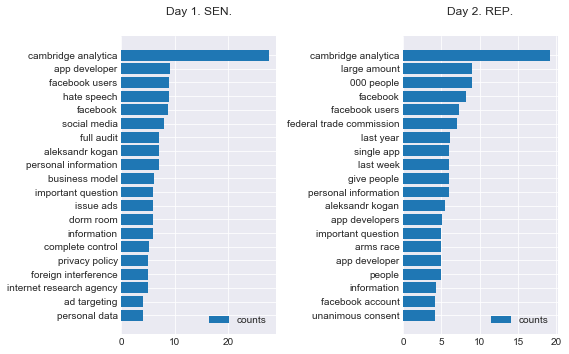

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8, 5)
plot_counter(ax1, collection_keywords(h1), n=20, title='Day 1. SEN.')
plot_counter(ax2, collection_keywords(h2), n=20, title='Day 2. REP.')
plt.tight_layout()
plt.show()

In [5]:
hs = h1.append(h2)
witness  = hs[hs.role == 'WITNESS']
congress = hs[hs.role == 'CONGRESS']

wkeys = collection_keywords(witness)
ckeys = collection_keywords(congress)

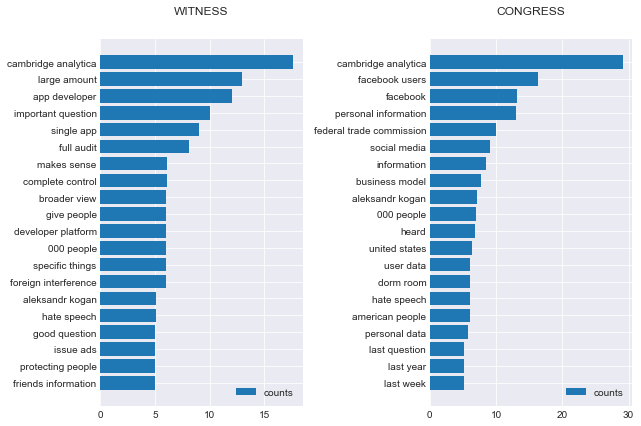

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(9, 6)
plot_counter(ax1, wkeys, n=20, title='WITNESS')
plot_counter(ax2, ckeys, n=20, title='CONGRESS')
plt.tight_layout()
plt.show()

In [7]:
print_overlaps(wkeys, ckeys)

WITNESS                        BOTH                           CONGRESS                      
---------------------------------------------------------------------------------------------
large amount                   cambridge analytica            facebook users                
app developer                  facebook                       personal information          
important question             000 people                     federal trade commission      
single app                     aleksandr kogan                social media                  
full audit                     hate speech                    heard                         
complete control               information                    united states                 
makes sense                    dorm room                      american people               
broader view                   business model                 user data                     
developer platform             give people                    persona

In [8]:
# print(hs.words.sum())
T = hs.words.sum()
print(witness.words.sum() / T)
print(congress.words.sum() / T)


0.369665798705
0.630334201295


## ngrams

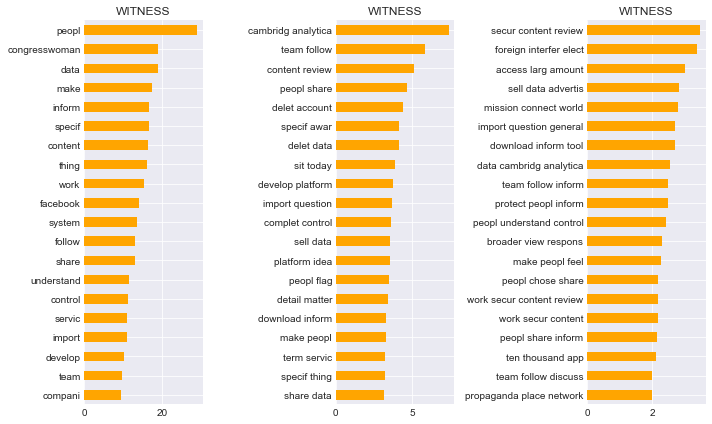

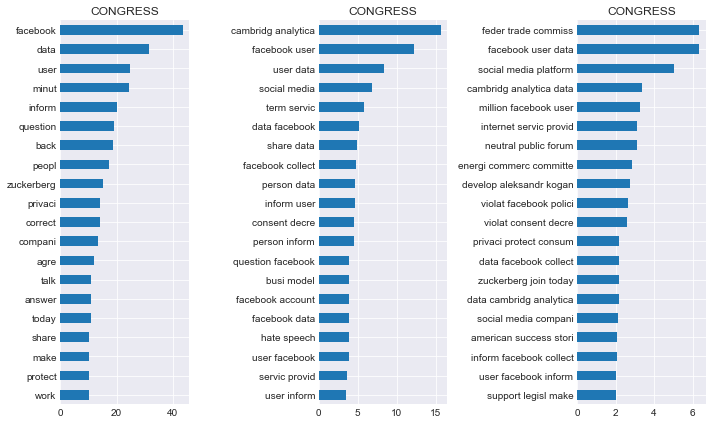

In [9]:
plot_ngrams(witness.cleaned, 1, 4, color='orange', title='WITNESS')
plot_ngrams(congress.cleaned, 1, 4, title='CONGRESS')

## Topic extraction

Here will use Non-Negative Matrix Factorisation NMF to extract topics from the transcripts with the groups split between the witness and congress and then finally all together. This may be useful for 1) describing the data, 2) forming the basis for qualitatively defined topics that then can be used to further decribe the data.

As the NMF works with anything we can get resonable results from TF-IDF scoring this may be usefull for cross comparison between different datasets of different kinds. E.g. bettween social media and news media.

In [10]:
extract_topics(congress.cleaned, 'CONGRESS topics', n_topics=5, n_samples=25)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features,
number of topics=5
n_samples=25 and n_features=5000...
time: 0.17 secs
iters 50


### Qualitative summary of Congress topics.

**1) Campaign data (specfically this one)**

**2) Facebooks control and collection of data**

**3) User privacy and data protection**

In [11]:
extract_topics(witness.cleaned,  'WITNESS topics', n_topics=5, n_samples=25)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features,
number of topics=5
n_samples=25 and n_features=5000...
time: 0.14 secs
iters 50


## Language use

Difference in language use. Congress describe Facebooks users as users. Mark describes Facebooks users as people. That people share. Also the word platform is not really used by congress.

In [12]:
extract_topics(hs.cleaned,  'All topics', n_topics=5, n_samples=25)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features,
number of topics=5
n_samples=25 and n_features=5000...
time: 0.28 secs
iters 50
